In [1]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
import nibabel as nib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
# from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=100) # this needs to be modified for some tasks
print('%i regions found in this atlas' % (len(np.unique(nib.load(yeo.maps).get_data().ravel())) 
- 1))
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, 
memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == b'F', dtype=np.int) # gives 1 for females and 0 for males

train_input = input_variables[:80]
train_output = output_variable[:80]

test_input = input_variables[80:]
test_output = output_variable[80:]

     |████████████████████████████████| 10.0 MB 9.2 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/oasis1



Downloaded 884875264 of 905208634 bytes (97.8%,    0.7s remaining) ...done. (30 seconds, 0 min)
Extracting data from /root/nilearn_data/oasis1/adcb228c7b26ed4f4fba93bd32bf8d97/archive_dartel.tgz..... done.
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)



Dataset created in /root/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


100 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation fo

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


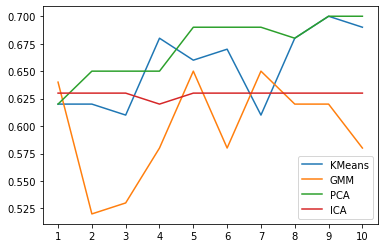

In [3]:
def plot_each_k_cluster(i):
  ### K-means ####
  kmeans = KMeans(n_clusters=i).fit(train_input) ### feature engineering on train_split
  kmeans_input_variables= kmeans.transform(input_variables)
  # kmeans_test_input = kmeans.transform(test_input)

  ### GMM ####
  GMM = GaussianMixture(n_components=i).fit(train_input) ### feature engineering on train_split
  gmm_input_variables = GMM.predict_proba(input_variables)
  # GMM_test_input = GMM.predict_proba(test_input)

  ### PCA ####
  pca = PCA(n_components=i).fit(train_input) ### feature engineering on train_split
  pca_input_variables = pca.transform(input_variables)
  # pca_test_input = pca.transform(test_input)

  ### ICA ####
  ica = FastICA(n_components=i).fit(train_input) ### feature engineering on train_split
  ica_input_variables = ica.transform(input_variables)
  # ica_test_input = ica.transform(test_input)

  kf = KFold(n_splits=5)

  km_accuracy = 0
  gmm_accuracy = 0
  pca_accuracy = 0
  ica_accuracy = 0

  for train_index, test_index in kf.split(output_variable):
    ######### KMeans #########
    kmeans_X_train, kmeans_X_test = kmeans_input_variables[train_index], kmeans_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    kmeans_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(kmeans_X_train, y_train)
    kmeans_log_predict_output = kmeans_Logmodel.predict(kmeans_X_test)
    km_accuracy += np.sum(kmeans_log_predict_output == y_test)/len(y_test)

    ######### GMM #########
    gmm_X_train, gmm_X_test = gmm_input_variables[train_index], gmm_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    gmm_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(gmm_X_train, y_train)
    gmm_log_predict_output = gmm_Logmodel.predict(gmm_X_test)
    gmm_accuracy += np.sum(gmm_log_predict_output == y_test)/len(y_test)

    ######### PCA #########
    pca_X_train, pca_X_test = pca_input_variables[train_index], pca_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    pca_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(pca_X_train, y_train)
    pca_log_predict_output = pca_Logmodel.predict(pca_X_test)
    pca_accuracy += np.sum(pca_log_predict_output == y_test)/len(y_test)

    ######### ICA #########
    ica_X_train, ica_X_test = ica_input_variables[train_index], ica_input_variables[test_index]
    y_train, y_test = output_variable[train_index], output_variable[test_index]

    ica_Logmodel = LogisticRegression(penalty='l2',C=1.0).fit(ica_X_train, y_train)
    ica_log_predict_output = ica_Logmodel.predict(ica_X_test)
    ica_accuracy += np.sum(ica_log_predict_output == y_test)/len(y_test)

  return i, km_accuracy/5, gmm_accuracy/5, pca_accuracy/5, ica_accuracy/5 #, KNN_accuracy


x_list = [] ### n_rois
km_y_list = [] ### accuracy
gmm_y_list = [] ### accuracy
pca_y_list = [] ### accuracy
ica_y_list = [] ### accuracy

# KNN_y_list = []

for i in range (1,11):
  i, km_accuracy, gmm_accuracy, pca_accuracy, ica_accuracy = plot_each_k_cluster(i)

  # print("i: ", i,"accuracy: ", accuracy)
  x_list.append(i)
  # log_y_list.append(log_accuracy)
  # KNN_y_list.append(KNN_accuracy)
  km_y_list.append(km_accuracy)
  gmm_y_list.append(gmm_accuracy)
  pca_y_list.append(pca_accuracy)
  ica_y_list.append(ica_accuracy)

# print(x_list)
# print(log_y_list)
# print(KNN_y_list)
plt.xticks(x_list)
# plt.plot(x_list,log_y_list,label='LogReg')
# plt.plot(x_list,KNN_y_list,label='KNN')
plt.plot(x_list,km_y_list,label='KMeans')
plt.plot(x_list,gmm_y_list,label='GMM')
plt.plot(x_list,pca_y_list,label='PCA')
plt.plot(x_list,ica_y_list,label='ICA')
plt.legend()
plt.show()